In [1]:
#r "nuget: BenchmarkDotNet, 0.13.9"
#r "nuget: Microsoft.Playwright, 1.39.0"
#r "nuget: NUlid, 1.7.1"
#r "nuget: SixLabors.ImageSharp, 3.0.2"
#r "nuget: SixLabors.ImageSharp.Drawing, 2.0.0"
#r "bin/Release/net6.0/ConsoleBenchmark.dll"

using ConsoleBenchmark;

Installed Packages BenchmarkDotNet, 0.13.9 Microsoft.Playwright, 1.39.0 NUlid, 1.7.1 SixLabors.ImageSharp, 3.0.2 SixLabors.ImageSharp.Drawing, 2.0.0

In [2]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var jsonElement = await fixture.Expression1JsonElementEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(PlaywrightFixture.Expression1JsonElementEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression1JsonElementEvaluateAsync: 15ms


In [3]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var gameState = await fixture.Expression2StringDeserializeEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(PlaywrightFixture.Expression2StringDeserializeEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression2StringDeserializeEvaluateAsync: 18ms



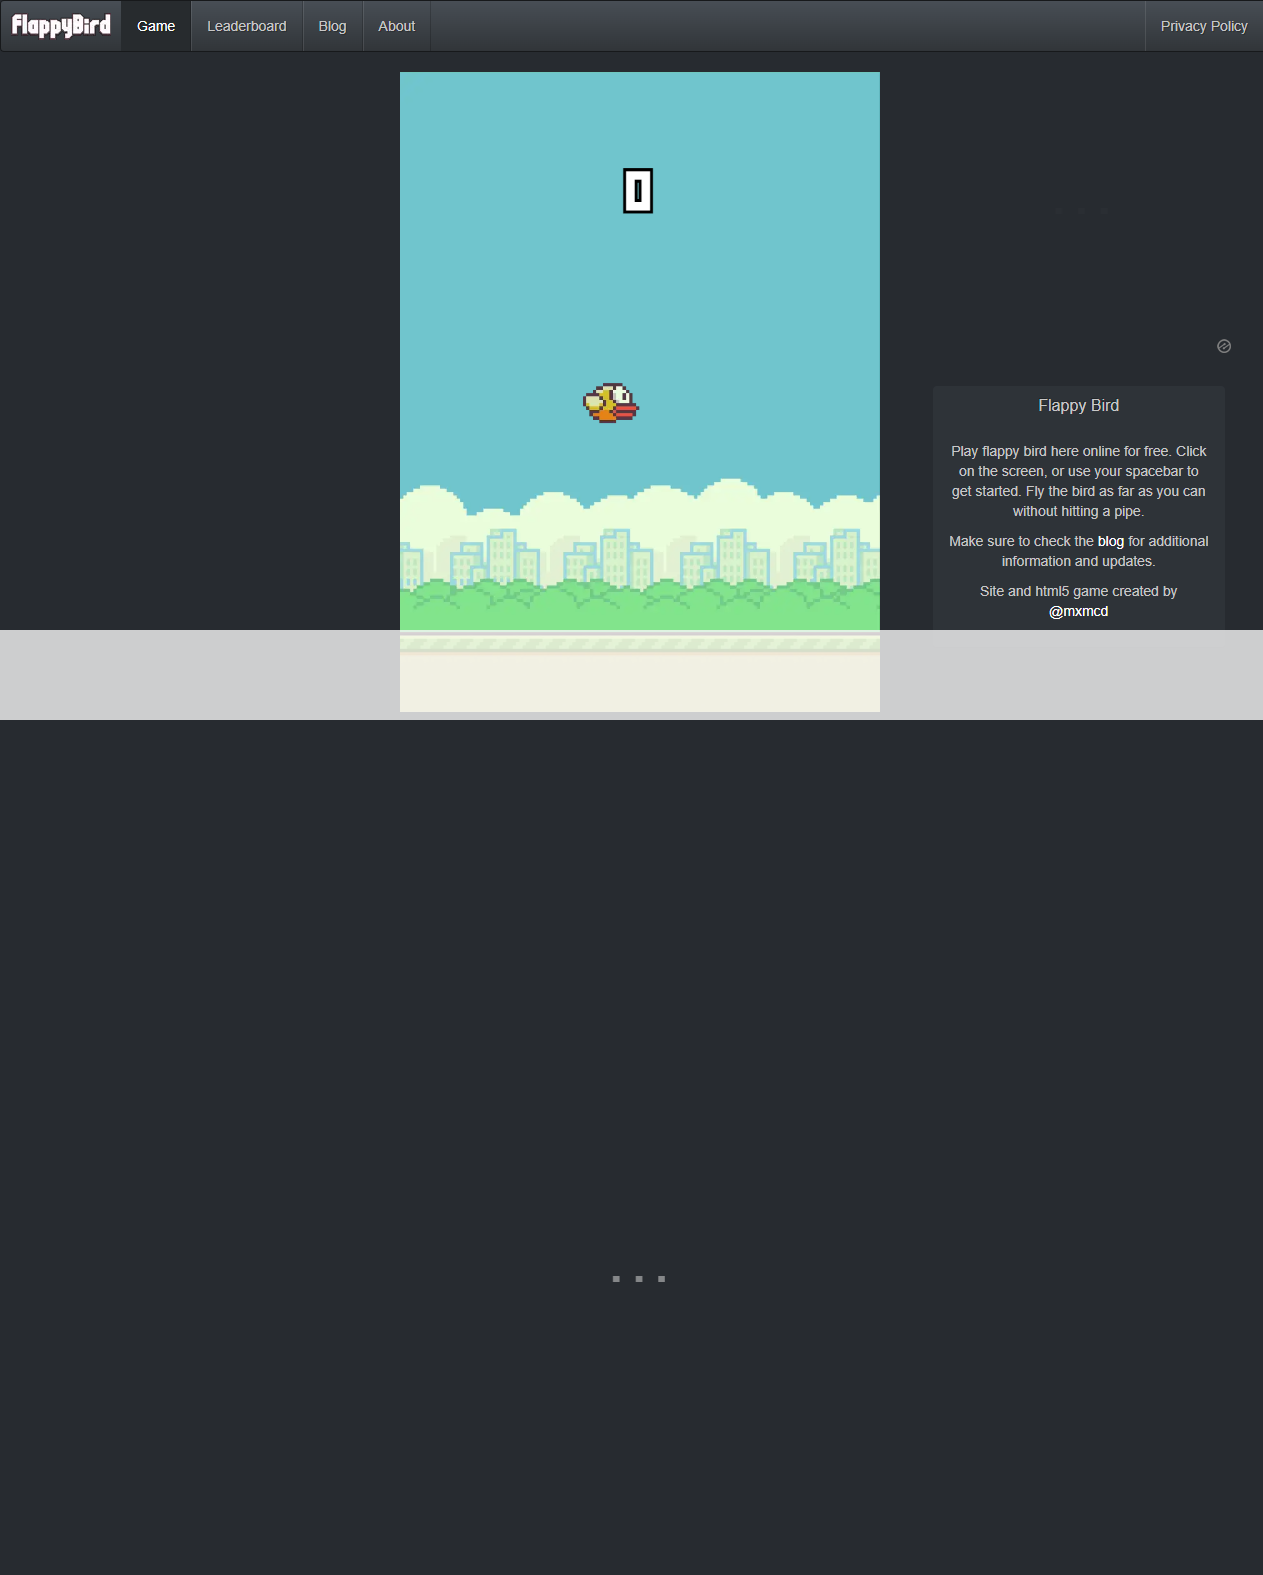

ScreenshotBytesAsync: 246ms


In [4]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.ScreenshotBytesAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.ScreenshotBytesAsync)}: {stopWatch.ElapsedMilliseconds}ms");


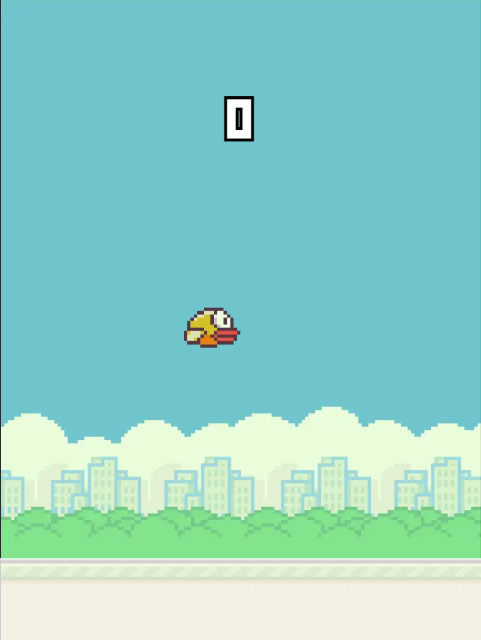

QuerySelectorAsyncScreenshotAsync: 172ms


In [5]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.QuerySelectorAsyncScreenshotAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.QuerySelectorAsyncScreenshotAsync)}: {stopWatch.ElapsedMilliseconds}ms");

c:\Users\Mmati\Source\Repos\Playwright.Benchmarks\ConsoleBenchmark\bin\Release\net6.0\01HDAYGYRTHWZ0YZ69KSJBAAFY.png


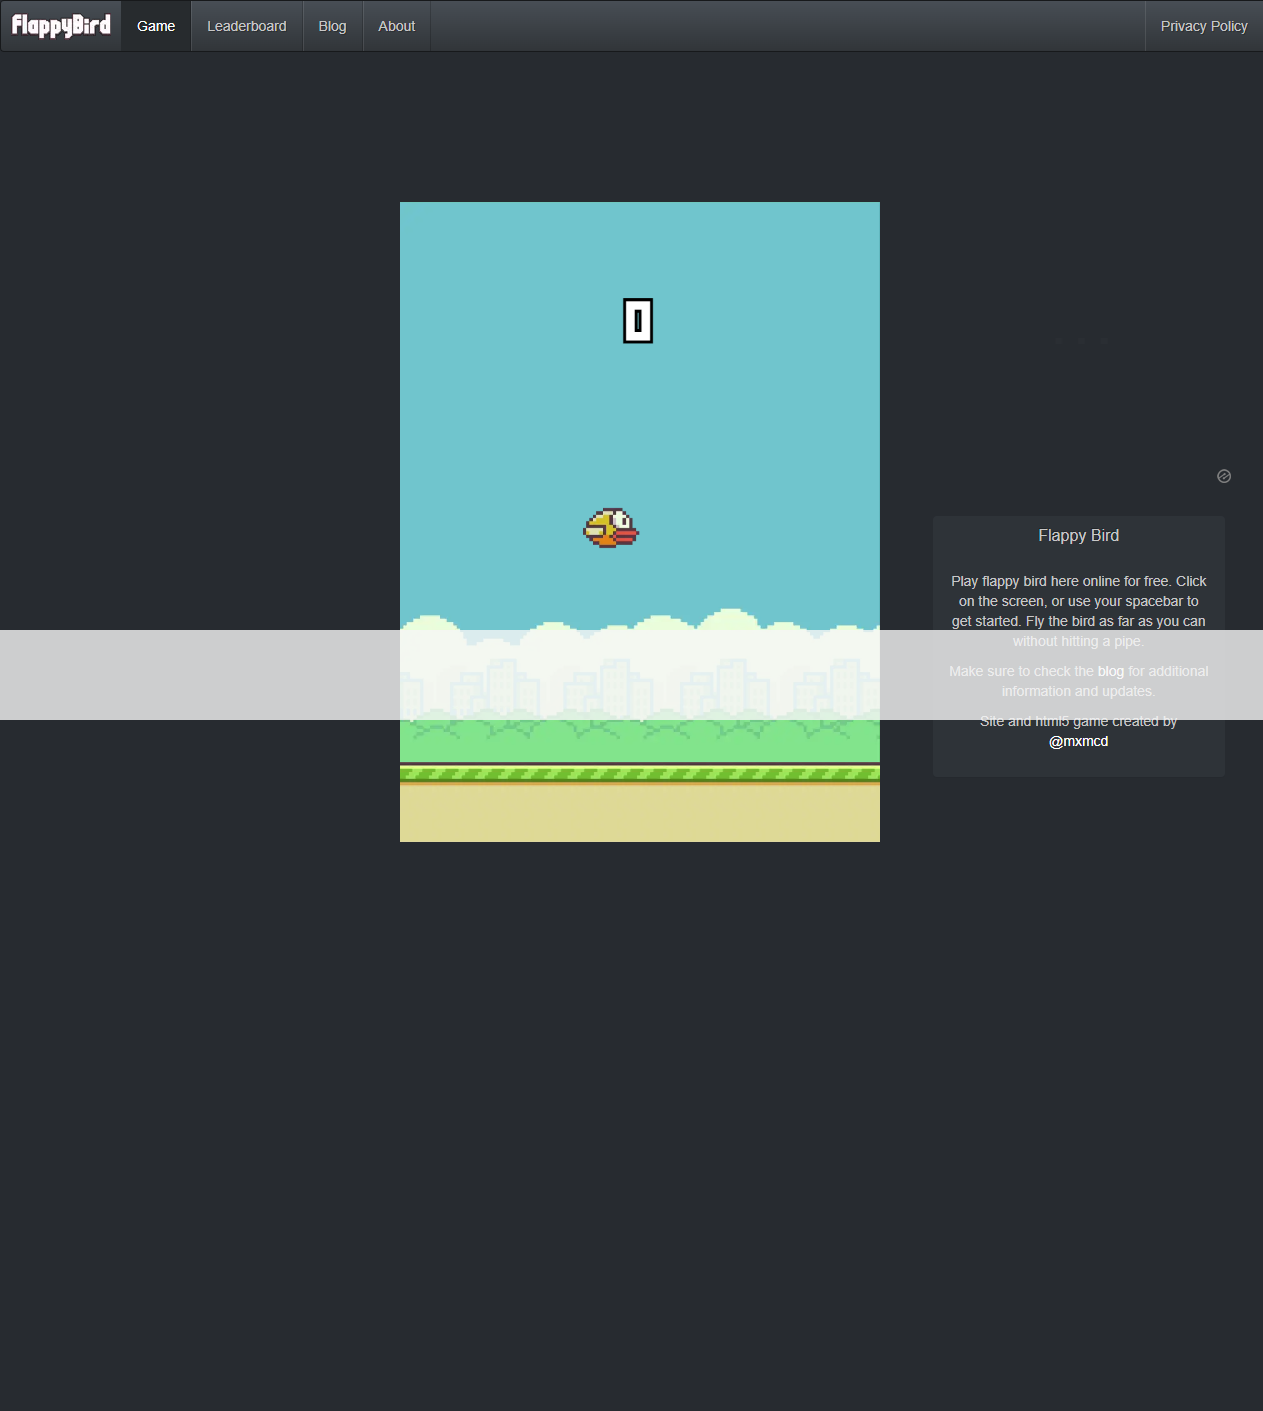

ScreenshotSaveAsync: 236ms


In [6]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var path = await fixture.ScreenshotSaveAsync();
    stopWatch.Stop();
    var screenshotBytes = await System.IO.File.ReadAllBytesAsync(path);
    var base64str = Convert.ToBase64String(screenshotBytes);
    display(path);
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.ScreenshotSaveAsync)}: {stopWatch.ElapsedMilliseconds}ms");

In [7]:
using NUlid;

Ulid newUlid = Ulid.NewUlid();
Console.WriteLine(newUlid);

01HDAYGZ86KX52W3NGN89GA4QP



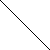


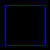

In [8]:
using System;
using System.IO;
using System.Drawing;
using System.Drawing.Imaging;
using Microsoft.DotNet.Interactive.Formatting;

MemoryStream memStream;
Bitmap b = new Bitmap(50, 50);
Graphics g = Graphics.FromImage(b);

void d()
{
memStream = new MemoryStream();
b.Save(memStream, ImageFormat.Png);
string base64str = Convert.ToBase64String(memStream.ToArray());
display(PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}

g.Clear(System.Drawing.Color.White);
g.DrawLine(System.Drawing.Pens.Black, 0, 0, b.Width, b.Height);
d();

g.Clear(System.Drawing.Color.Black);
g.DrawRectangle(System.Drawing.Pens.Blue, 5, 5, b.Width-10, b.Height-10);
d();

In [9]:
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "https://www.youtube.com/embed/-1pVLJl_snc?si=b72ci--nGXhEGYy8&amp;start=163", width: 560, height: 315]);

In [10]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var path = await fixture.ScreenshotSaveAsync();
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: path.Replace(System.IO.Directory.GetCurrentDirectory(), ".")]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.ScreenshotSaveAsync)}: {stopWatch.ElapsedMilliseconds}ms");

ScreenshotSaveAsync: 233ms


01HDAYH30S0Q0EZ4RXTYKG678M



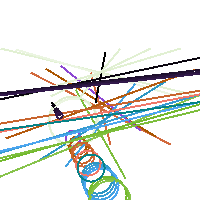

In [11]:
using NUlid;
using System;
using System.IO;
using System.Drawing;
using System.Drawing.Imaging;
using Microsoft.DotNet.Interactive.Formatting;

Bitmap b = new Bitmap(200, 200);
Graphics g = Graphics.FromImage(b);

void d()
{
    MemoryStream memStream = new MemoryStream();
    b.Save(memStream, ImageFormat.Png);
    string base64str = Convert.ToBase64String(memStream.ToArray());
    display(PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}

Ulid newUlid = Ulid.NewUlid();
Console.WriteLine(newUlid);

// Clear canvas
g.Clear(System.Drawing.Color.White);

// Start drawing based on the ULID
for (int i = 0; i < newUlid.ToString().Length; i++)
{
    char c = newUlid.ToString()[i];
    int value = (int)c;

    // Use value to set color
    System.Drawing.Color color = System.Drawing.Color.FromArgb(value * 10 % 255, value * 5 % 255, value * 15 % 255);
    using System.Drawing.Pen pen = new System.Drawing.Pen(color, 2);

    // Draw some graphics
    g.DrawEllipse(pen, value % b.Width, (value * 2) % b.Height, value % 50, value % 50);
    g.DrawLine(pen, i * 15, value % b.Height, b.Width - i * 15, (value * 2) % b.Height);
}

d();



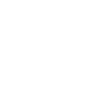

In [12]:
using System;
using System.Drawing;
using SixLabors.ImageSharp.Drawing;
using System.Collections.Generic;
using SixLabors.ImageSharp;
using SixLabors.ImageSharp.PixelFormats;
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Formats.Gif;
using Microsoft.DotNet.Interactive.Formatting;
using SixLabors.ImageSharp.Drawing.Processing;

// Parameters
int width = 100;
int height = 100;
int numberOfFrames = 10;
int circleDiameter = 20;

// Create individual frames
Image<Rgba32>[] frames = new Image<Rgba32>[numberOfFrames];

for (int i = 0; i < numberOfFrames; i++)
{
    var image = new Image<Rgba32>(width, height);
    int positionX = i * (width - circleDiameter) / (numberOfFrames - 1);

    image.Mutate(ctx => ctx.Fill(Rgba32.ParseHex("#333333"))  // Background color
                        .Fill(Rgba32.ParseHex("#df3079"), new EllipsePolygon(positionX + circleDiameter / 2, height / 2, circleDiameter / 2)));  // Moving circle
    
    frames[i] = image;
}

// Create the GIF
var outputImage = new Image<Rgba32>(width, height);
for (int i = 0; i < numberOfFrames; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    outputImage.Frames[i].Metadata.GetFormatMetadata(GifFormat.Instance).FrameDelay = 100;  // 100ms delay = 10fps
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream()){    
    outputImage.Metadata.GetFormatMetadata(GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}


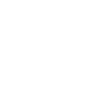

In [13]:
using System;
using System.Drawing;
using SixLabors.ImageSharp.Drawing;
using System.Collections.Generic;
using SixLabors.ImageSharp;
using SixLabors.ImageSharp.PixelFormats;
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Formats.Gif;
using Microsoft.DotNet.Interactive.Formatting;
using SixLabors.ImageSharp.Drawing.Processing;
using SixLabors.Fonts;

// Parameters
int width = 100;
int height = 100;
int numberOfFrames = 26;  // Length of a ULID
Dictionary<char, Rgba32> ulidColorMap = new Dictionary<char, Rgba32>
{
    // This is just a sample mapping. You can change colors as you see fit.
    {'0', Rgba32.ParseHex("#df3079")},
    {'1', Rgba32.ParseHex("#2e95d3")},
    {'2', Rgba32.ParseHex("#00a67d")},
    //... Add other characters from ULID here with corresponding colors.
};

Ulid newUlid = Ulid.NewUlid();
var ulidStr = newUlid.ToString();

// Create individual frames
Image<Rgba32>[] frames = new Image<Rgba32>[numberOfFrames];

for (int i = 0; i < numberOfFrames; i++)
{
    var image = new Image<Rgba32>(width, height);
    
    if (i < ulidStr.Length && ulidColorMap.TryGetValue(ulidStr[i], out var color))
    {
        image.Mutate(ctx => ctx.Fill(color));  // Fill with color based on ULID's character
    }
    else
    {
        image.Mutate(ctx => ctx.Fill(Rgba32.ParseHex("#808080")));  // Default color if ULID is shorter or character not mapped
    }

    frames[i] = image;
}

// Create the GIF
var outputImage = new Image<Rgba32>(width, height);
for (int i = 0; i < numberOfFrames; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    outputImage.Frames[i].Metadata.GetFormatMetadata(GifFormat.Instance).FrameDelay = 100;  // 100ms delay = 10fps
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream())
{    
    outputImage.Metadata.GetFormatMetadata(GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}



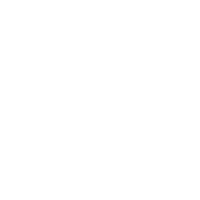

In [14]:
using System;
using System.Drawing;
using SixLabors.ImageSharp.Drawing;
using System.Collections.Generic;
using SixLabors.ImageSharp;
using SixLabors.ImageSharp.PixelFormats;
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Formats.Gif;
using Microsoft.DotNet.Interactive.Formatting;
using SixLabors.ImageSharp.Drawing.Processing;

// Parameters
int width = 200;
int height = 200;
int numberOfFrames = 30;
float frequency = 2.0f * (float)Math.PI / width;
float amplitude = 50;

// Create individual frames
Image<Rgba32>[] frames = new Image<Rgba32>[numberOfFrames];

for (int t = 0; t < numberOfFrames; t++)
{
    var image = new Image<Rgba32>(width, height);

    image.Mutate(ctx => 
    {
        ctx.Fill(Rgba32.ParseHex("#333333"));  // Background color

        SixLabors.ImageSharp.PointF[] points = new SixLabors.ImageSharp.PointF[width];
        for (int x = 0; x < width; x++)
        {
            int y = (int)(height / 2 + amplitude * Math.Sin(frequency * x + ((float)t/numberOfFrames) * 2.0f * Math.PI));
            points[x] = new SixLabors.ImageSharp.PointF(x, y);
        }
        ctx.DrawPolygon(Rgba32.ParseHex("#2e95d3"), 2, points);
    });
    
    frames[t] = image;
}

// Create the GIF
var outputImage = new Image<Rgba32>(width, height);
for (int i = 0; i < numberOfFrames; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    outputImage.Frames[i].Metadata.GetFormatMetadata(GifFormat.Instance).FrameDelay = 100;  // 100ms delay = 10fps
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream())
{    
    outputImage.Metadata.GetFormatMetadata(GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}
